# 카메라 스티커앱 만들기 첫걸음

카메라앱 만들기를 통해 동영상 처리, 검출, 키포인트 추정, 추적, 카메라 원근 의 기술을 다룸  
간단한 스티커부터 시작해서 각도 변화가 가능하고 거리 변화에 강건한 스티커 까지 만들 수 있다.

**목표** :  
얼굴인식 카메라의 흐름을 이해  
dlib 라이브러리 사용  
이미지 배열의 인덱싱 예외 처리  


## 1. 어떻게 만들까? 사진 준비하기

- 얼굴이 포함된 사진을 준비하고  
- 사진으로부터 얼굴 영역 face landmark 를 찾아낸다. (landmark를 찾기 위해서는 얼굴의 bounding box를 먼저 찾는다.)  
- 찾아진 영역으로 부터 머리에 왕관 스티커를 붙여넣여 넣는다.



In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
print("🌫🛸")

🌫🛸


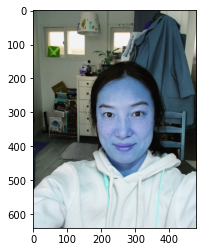

In [9]:
# 준비된 사진 가져오기
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_joo2.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (480,640)) # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

### opencv의 특징
matplotlib, dlib 등의 이미지 라이브러리는 모두 이미지 채널을 RGB(빨강, 녹색, 파랑) 순으로 사용  
그런데 opencv는 예외적으로 BGR(파랑, 녹색, 빨강)을 사용  
그래서 원본 사진에서 붉은색은 푸른색으로, 푸른색은 붉은색으로 바뀌어 출력

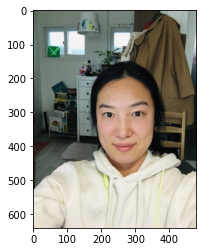

In [10]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 2. 얼굴 검출 face detection
Object detection 기술을 이용  
dlib 의 face detector는 HOG(Histogram of Oriented Gradient) feature를 사용해서  
SVM(Support Vector Machine)의 sliding window로 얼굴을 찾는다.

In [11]:
# dlib을 활용해 hog detector를 선언
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸")

🌫🛸


In [12]:
# detector를 이용해서 얼굴의 bounding box를 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # 1 - (image, num of img pyramid) 
                                        # 이미지를 upsampling 방법을 통해 크기를 키우는 것을 이미지 피라미드라고 함. 
print("🌫🛸")

🌫🛸


### Image Pyramids 
동일 이미지의 서로 다른 사이즈의 set을 Image Pyramids

일반적으로는 고정된 이미지 사이즈를 작업을 하지만, 때때로 동일한 이미지에 대해서 다양한 사이즈를 가지고 작업을 해야 하는 경우가 있다. 만일, 이미지에서 얼굴을 찾을 경우에 얼굴의 사이즈를 확신할 수 없다. 이럴 경우에는 원본 이미지에 대한 다양한 사이즈에서 얼굴을 찾는다면 좀더 정확하고 확실한 이미지를 찾을 수 있다. 이 처럼 동일 이미지의 서로 다른 사이즈의 set을 Image Pyramids라고 한다.(가장 아래에 가장 큰 해상도를 놓고 점점 줄여가면서 쌓아가는 형태입니다.)

이미지 Pyramid를 이용하면 이미지 결합을 자연스럽게 처리할 수 있다.

### Object detection 으로 찾은 얼굴에 그린색 박스 생성

rectangles[[(180, 263) (366, 449)]]


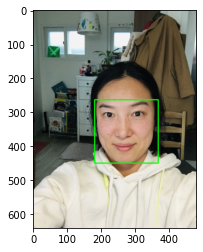

In [13]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3. 얼굴 랜드마크 face landmark

이목구비의 위치를 추론하는 것을 face landmark localization 기술.   
face landmark는 detection 의 결과물인 bounding box 로 잘라낸(crop) 얼굴 이미지를 이용

### Object keypoint estimation 알고리즘
1) top-down : bounding box를 찾고 box 내부의 keypoint를 예측  
2) bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성  

### Dlib landmark localization
잘라진 얼굴 이미지에서 아래 68개의 이목구비 위치를 찾습니다. 점의 개수는 데이터셋과 논문마다 다름.  
Dlib은 ibug 300-W 데이터셋으로 학습한 pretrained model 을 제공 - 학습 알고리즘은 regression tree의 앙상블 모델을 사용

In [14]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환
print("🌫🛸")

🌫🛸


In [15]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
# points 는 dlib.full_object_detection 의 객체이기 때문에 parts() 함수로 개별 위치에 접근할 수 있다.
# list_points 는 tuple (x, y) 68개로 이루어진 리스트
# 이미지에서 찾아진 얼굴 개수마다 반복하면 list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장
print(len(list_landmarks[0]))


68


### 68 개의 랜드마크를 노란색 point로 표현

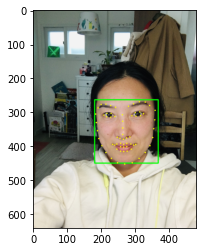

In [16]:
for landmark in list_landmarks:
    #print(landmark)
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow
            
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 4. 스티커 적용하기

얼굴 index를 이용해 좌표값을 정하고 조정한다.
<img src="face_index.png" width="400px" height="400px"></img><br/>

In [17]:
# 좌표를 먼저 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] #- dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print (dlib_rect.width()//2)
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(262, 365)
93
(x,y) : (262,365)
(w,h) : (187,187)


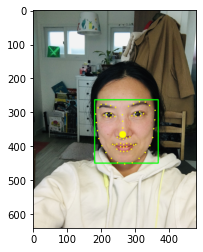

In [18]:
# index 30 일 때 코 중앙에 찍힌 노란점 
cv2.circle(img_show, (262, 365), 10, (0, 255, 255), -1) # yellow          
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [19]:
# 준비해 둔 스티커 이미지를 읽어서 적용
# 얼굴영역 사각형의 1/3만큼 크기 조절 
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(187, 187, 3)


In [20]:
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표
refined_x = x  - w // 2  # left
refined_y = y  - h //2     # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (169,272)


In [21]:
img_show.shape

(640, 480, 3)

### 원본 이미지에 스티커를 적용 
원본이미지의 스티커 영역에 스티커 이미지를 적용한다. 
스티커 이미지의 각 픽셀이 가진 값이 흰색(255)이면 원본이미지 그대로 아니면 스티커 이미지로 채운다. 

In [22]:
# 원본 이미지에 스티커를 적용 
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

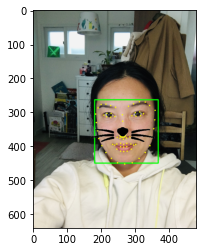

In [23]:
# 결과 이미지 
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

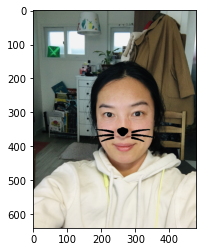

In [24]:
# 원본 이미지에 스티커를 적용 
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 5. 오늘 만든 스티커앱에서 생각해볼 수 있는 문제점

- 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
- 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
- 실행 속도가 중요할까요?
- 스티커앱을 만들 때 정확도가 얼마나 중요할까요?

### 얼굴 각도 변경

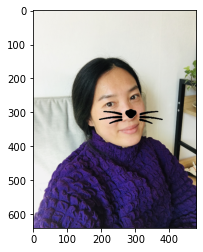

In [40]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_joo.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (480,640)) # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관

# dlib을 활용해 hog detector를 선언
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

# detector를 이용해서 얼굴의 bounding box를 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # 1 - (image, num of img pyramid) 

# 준비된 모델로 landmark_predictor 생성
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# list_landmarks에 68개의 랜드마크 저장
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# 좌표를 먼저 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = landmark[30][1] #- dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()  

# 준비해 둔 스티커 이미지를 읽어서 적용
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))

# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표
refined_x = x  - w // 2  # left
refined_y = y  - h //2     # top

# 원본 이미지에 스티커를 적용 
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

# 결과 이미지 
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 멀리서 촬영한 사진

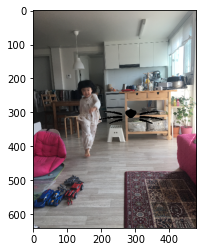

In [46]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_hong.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (480,640)) # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관

# dlib을 활용해 hog detector를 선언
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

# detector를 이용해서 얼굴의 bounding box를 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # 1 - (image, num of img pyramid) 

# 준비된 모델로 landmark_predictor 생성
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# list_landmarks에 68개의 랜드마크 저장
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# 좌표를 먼저 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = landmark[30][1] #- dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()  

# 준비해 둔 스티커 이미지를 읽어서 적용
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))

# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표
refined_x = x  - w // 2  # left
refined_y = y  - h //2     # top

# 원본 이미지에 스티커를 적용 
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

# 결과 이미지 
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 느낀점 

얼굴각도를 변경했을 때는 수염을 코로 기준하여 나오긴 하였으나 각도에 따라 수염이 회전을 해야될 거 같다.  
멀리서 찍은 얼굴에 대해서는 landmark를 찾을 수가 없는 거 같고, 위치를 찾을 수 없으니 수염이 붙질 않았다.  

정적인 사진으로 스티커앱을 수행했으나, 동영상등 사람이 움질일 경우에는 그 움직임을 잘 포착하여  
얼굴의 landmark를 찾아야할거 같다. 이때에는 landmark를 예측해내는 속도도 빨라야 하지 싶다.  

landmark를 정확하게 예측해 내는 것이 스티커앱의 중요한 핵심인거 같다.  
 
이번 프로젝트에서 아쉬운 점은 중복되는 코드를 함수화 하고 싶었으나, 잘 되지 않아서 아쉬움이 남는다.  
